# Exploratory Data Analysis on Unicorn Dataset

## **Data pre-processing**

In [77]:
# Load the dataset
import pandas as pd
import numpy as np

unicornData = pd.read_csv("/content/Unicorn_Companies.csv")

In [78]:
%%capture
# Show the dataset entries and properties for better understanding how the dataset looks like
print("First rows of Dataset: ", unicornData.head)
print("Description of the Dataset: ", unicornData.describe)
print("Shape of the Dataset: ", unicornData.shape)
print("Columns of the Dataset: ", unicornData.columns)

In [79]:
%%capture
# Check for the datatype and existing Null values in the dataset
unicornData.info()

#### The following cell is for converting data type of columns to the suitable data type for further analysis, arithmetic operations, time series analysis and so on.

In [80]:
%%capture
# Converting Valuation column to the float and also remove the dollar sign
unicornData['Valuation ($B)'] = unicornData['Valuation ($B)'].str.replace('$', '').astype('float64')
# Converting Date Joined Column to DateTime format and extract year
unicornData['Date Joined'] = pd.to_datetime(unicornData['Date Joined'])
unicornData['Year_Joined'] = unicornData['Date Joined'].dt.year

In [81]:
%%capture
# Countries in dataset
unicornData['Country'].value_counts()
# Cities in the dataset
unicornData['City'].value_counts()

#### Group the data for better visualization

In [82]:
%%capture
grouped1 = unicornData.groupby('Country')['City'].apply(list).reset_index()

# Creating a dictionary from the grouped DataFrame
country_city_dict = dict(zip(grouped1['Country'], grouped1['City']))
print(country_city_dict)

In [83]:
%%capture
import geopandas as gpd
import matplotlib.pyplot as plt

# Group by country and count the number of cities
grouped = unicornData.groupby('Country').size().reset_index(name='CityCount')

# Define macro regions based on the number of cities
macro_regions = {
    'North America': ['United States', 'Canada'],
    'South America': ['Brazil'],
    'Europe': ['Germany', 'United Kingdom', 'France','Israel'],  # We can add more European countries
    'Asia': ['China', 'India', 'Japan','Singapore','South Korea'],  # We can add more Asian countries
    # Or also another more macro-regions as needed
}

# Function to assign macro-region based on country
def assign_macro_region(country):
    for region, countries in macro_regions.items():
        if country in countries:
            return region
    return 'Other'  # If not in any macro-region, then assign as 'Other'

# Create a new column for macro-regions
grouped['MacroRegion'] = grouped['Country'].apply(assign_macro_region)

# Plot the macro-regions
# Load the world map shapefile using Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Merge world map with the macro-regions
world = world.merge(grouped, how='left', left_on='name', right_on='Country')


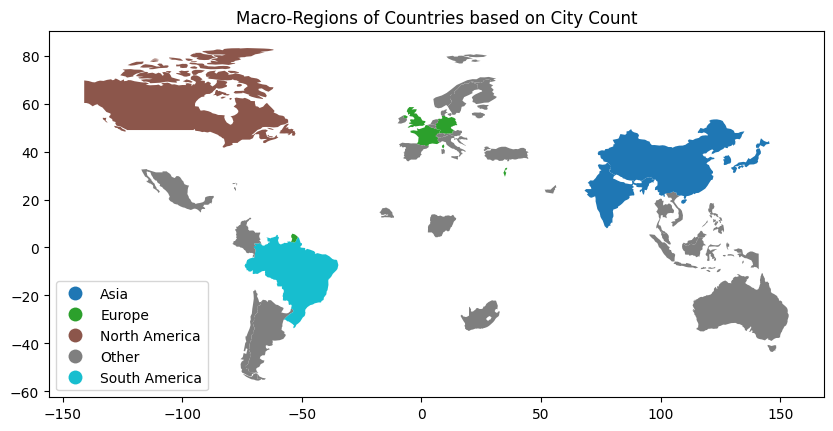

In [84]:
# Plot the world map with macro-regions colored
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
world.plot(column='MacroRegion', ax=ax, legend=True,
           legend_kwds={'loc': 'lower left'}, cmap='tab10')
ax.set_title('Macro-Regions of Countries based on City Count')
plt.show()

### Insights:
- The map shows which countries have a higher concentration of unicorn companies, as represented by the number of cities where these companies are located.
- We can observe broader patterns of unicorn company distribution across continents or regions. This can provide insights into economic development, investment trends, and technological innovation within each macro-region.

In [85]:
%%capture
# Filter countries with more than 15 cities count
countries_with_more_than_15_cities = list(grouped[grouped['CityCount'] > 15]['Country'])

# Create a dictionary with country names and their corresponding city counts
filtered_country_city_dict = {country: grouped[grouped['Country'] == country]['CityCount'].iloc[0] for country in countries_with_more_than_15_cities}

# Extract filtered countries and cities count
filtered_countries = list(filtered_country_city_dict.keys())
filtered_num_cities = list(filtered_country_city_dict.values())

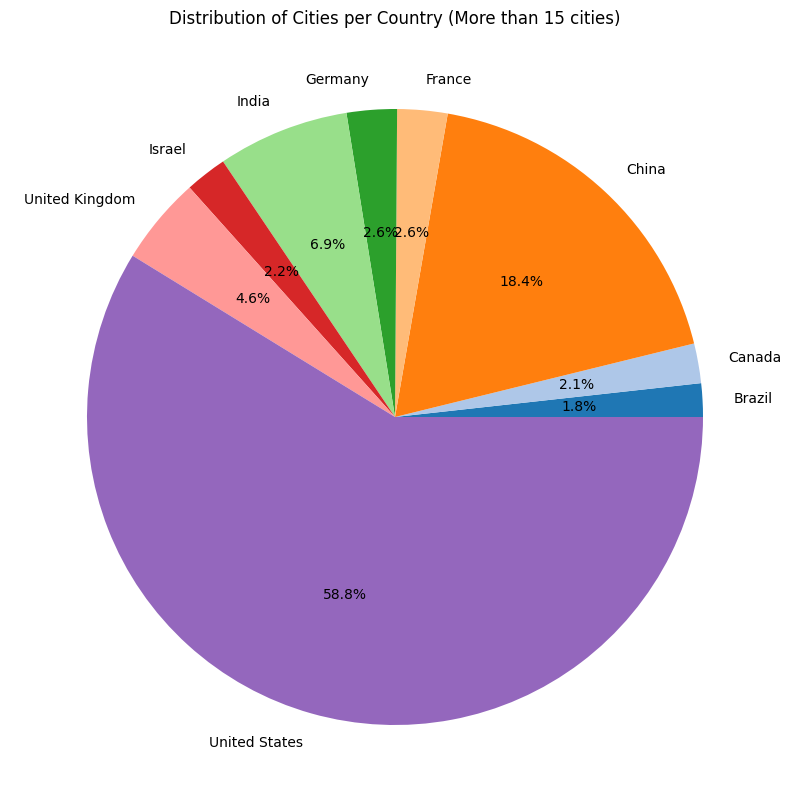

In [19]:
import matplotlib.pyplot as plt

# Plot the data using a pie chart
plt.figure(figsize=(10, 10))
plt.pie(filtered_num_cities, labels=filtered_countries, autopct='%1.1f%%', colors=plt.cm.tab20.colors)
plt.title('Distribution of Cities per Country (More than 15 cities)')
plt.show()

#### Insights:
- The plot illustrating the number of countries having more than 15 cities as macro-region, insight into the distribution of startup ecosystems. It showcases the geographic diversity of entrepreneurship and innovation hubs, where unicorn companies may emerge and thrive.
- The distribution of cities and unicorn companies across different countries may correlate with economic factors such as GDP, investment climate, and regulatory environment.
- These cities often attract entrepreneurs, investors, and talent, driving innovation, job creation, and economic growth.
- The pie chart highlights regions with a high density of urban centers, that indicates areas of significant population concentration, economic activity, and infrastructure development.

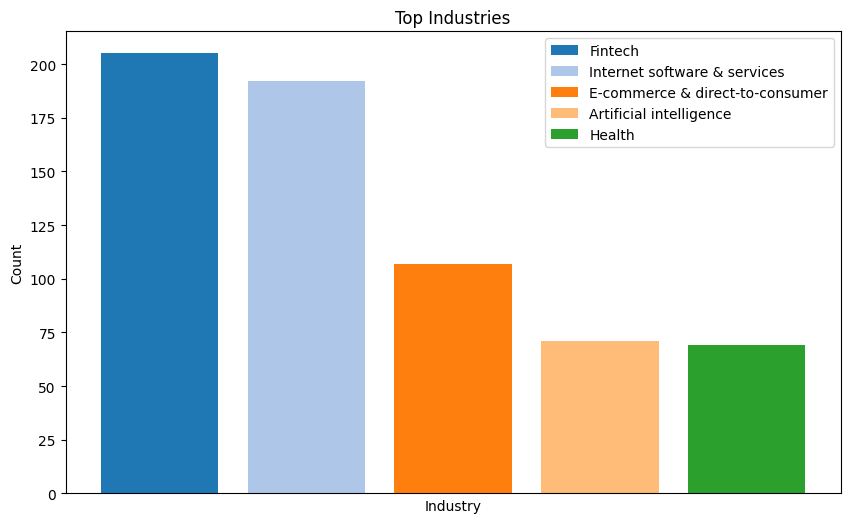

In [93]:
# Number of Industry types in the dataset
industry_counts = unicornData['Industry'].value_counts()

# Determine the threshold count for grouping industries
threshold_count = 60  # You can adjust it as needed

# Get the counts of the top industries
top_industries = industry_counts[industry_counts >= threshold_count]

# Plotting the data for top industries only with different colors for each bar

colors = plt.cm.tab20(np.arange(len(top_industries)))  # Generate different colors
plt.figure(figsize=(10, 6))
for i, (industry, count) in enumerate(top_industries.items()):
    plt.bar(industry, count, color=colors[i], label=industry)

plt.xlabel('Industry')
plt.ylabel('Count')
plt.title('Top Industries')
plt.xticks([])  # Remove x-axis ticks
plt.legend(top_industries.index, loc='upper right')  # Add legend with all labels
plt.show()

#### Insights:
- The plot helps in identifying which industries have a significant presence in the unicorn dataset. Industries with more presence  represent those that are more prevalent among the unicorn companies.
- The plot allows for easy comparison between different industries. Analysts can visually compare the counts of various industries and assess their relative importance within the dataset.


In [113]:
%%capture
import geopandas as gpd

# Load the world map shapefile using Geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Convert industry names to lowercase for normalization
unicornData['Industry'] = unicornData['Industry'].str.lower()
# Get the counts of the top industries also with the lowercase
top_industries1 = industry_counts[industry_counts >= threshold_count].index.str.lower()

# Filter dataset for entries where the industry is one of the top industries
top_industries_data = unicornData[unicornData['Industry'].isin(top_industries1)]

# Group by country and industry, then count the number of companies in each group
country_industry_counts = top_industries_data.groupby(['Country', 'Industry']).size().unstack(fill_value=0)

# Merge world map with country_industry_counts
world = world.merge(country_industry_counts, how='left', left_on='name', right_on='Country')

<Figure size 1400x1200 with 0 Axes>

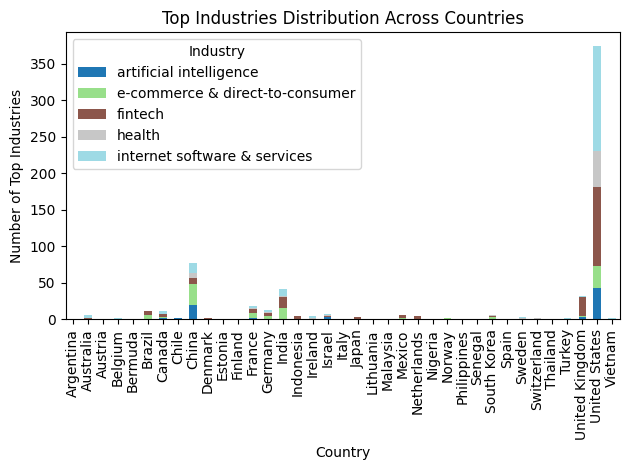

In [124]:
# Plotting the data
plt.figure(figsize=(14, 12))
country_industry_counts.plot(kind='bar', stacked=True, cmap='tab20')
plt.ylabel('Number of Top Industries')
plt.xlabel('Country')
plt.title('Top Industries Distribution Across Countries')
plt.yticks(rotation=0)  # Rotate y-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent overlapping labels
plt.show()

### Insights:
- The stacked bar plot shows the distribution of top industries within each country. It allows us to see which industries are dominant in each country.
- By comparing the heights of the bars for different countries, we can observe which countries have a higher number of top industries overall.
- The distribution of industries within each country reveals the diversity of economic activities.


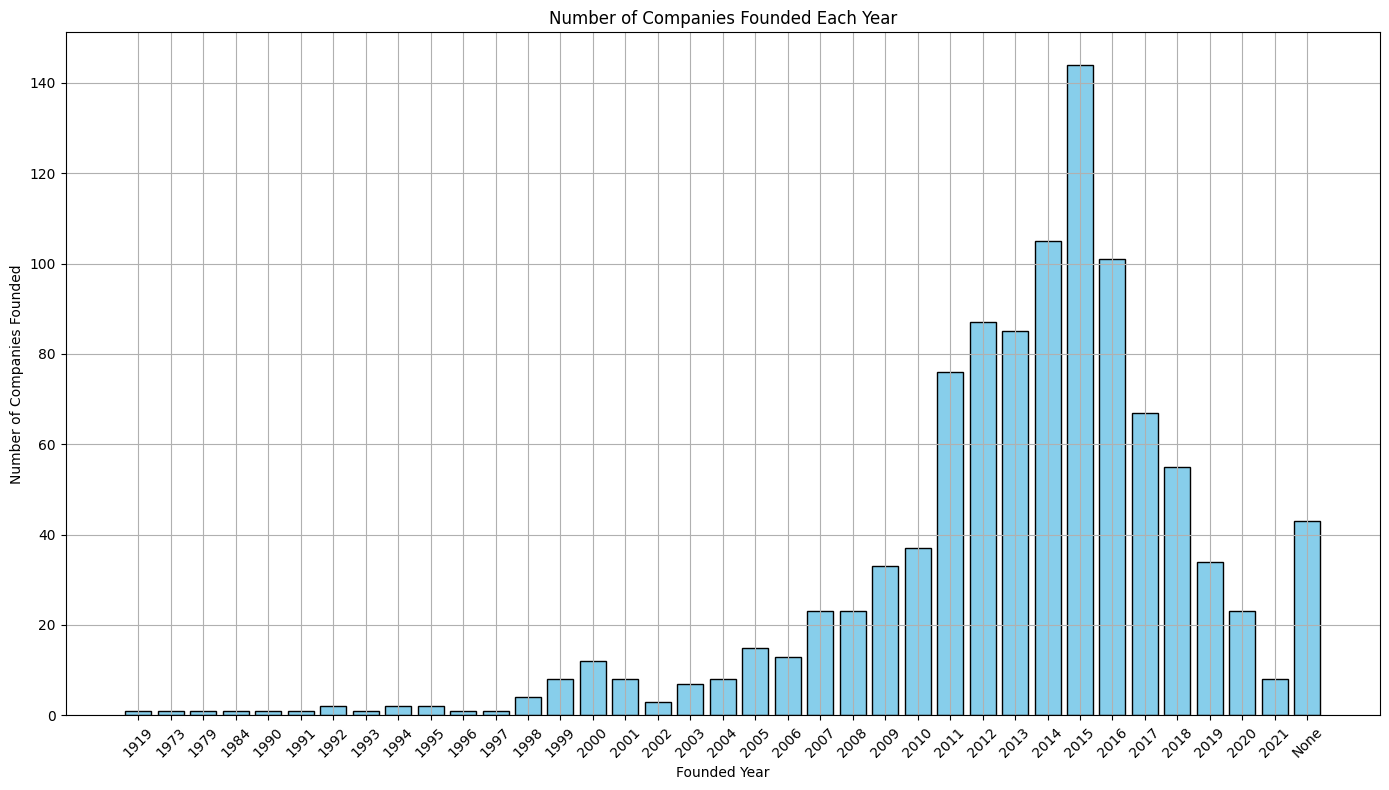

In [130]:
# Drop rows with missing values in the 'Founded Year' column
df_cleaned = unicornData.dropna(subset=['Founded Year'])

# Group by 'Founded Year' and aggregate the count of companies and the list of companies
grouped = df_cleaned.groupby('Founded Year')['Company'].agg(['count', list])

# Plotting a bar chart
plt.figure(figsize=(14, 8))
bars = plt.bar(grouped.index, grouped['count'], color='skyblue', edgecolor='black')
plt.xlabel('Founded Year')
plt.ylabel('Number of Companies Founded')
plt.title('Number of Companies Founded Each Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

### Insights:
- The bar chart provides a clear view of the number of companies founded each year.
- Patterns in the number of companies founded each year can indicate periods of growth or decline in entrepreneurship. Sharp increases in the number of companies founded may suggest favorable economic conditions or technological advancements and declines may signal economic downturns in industry.


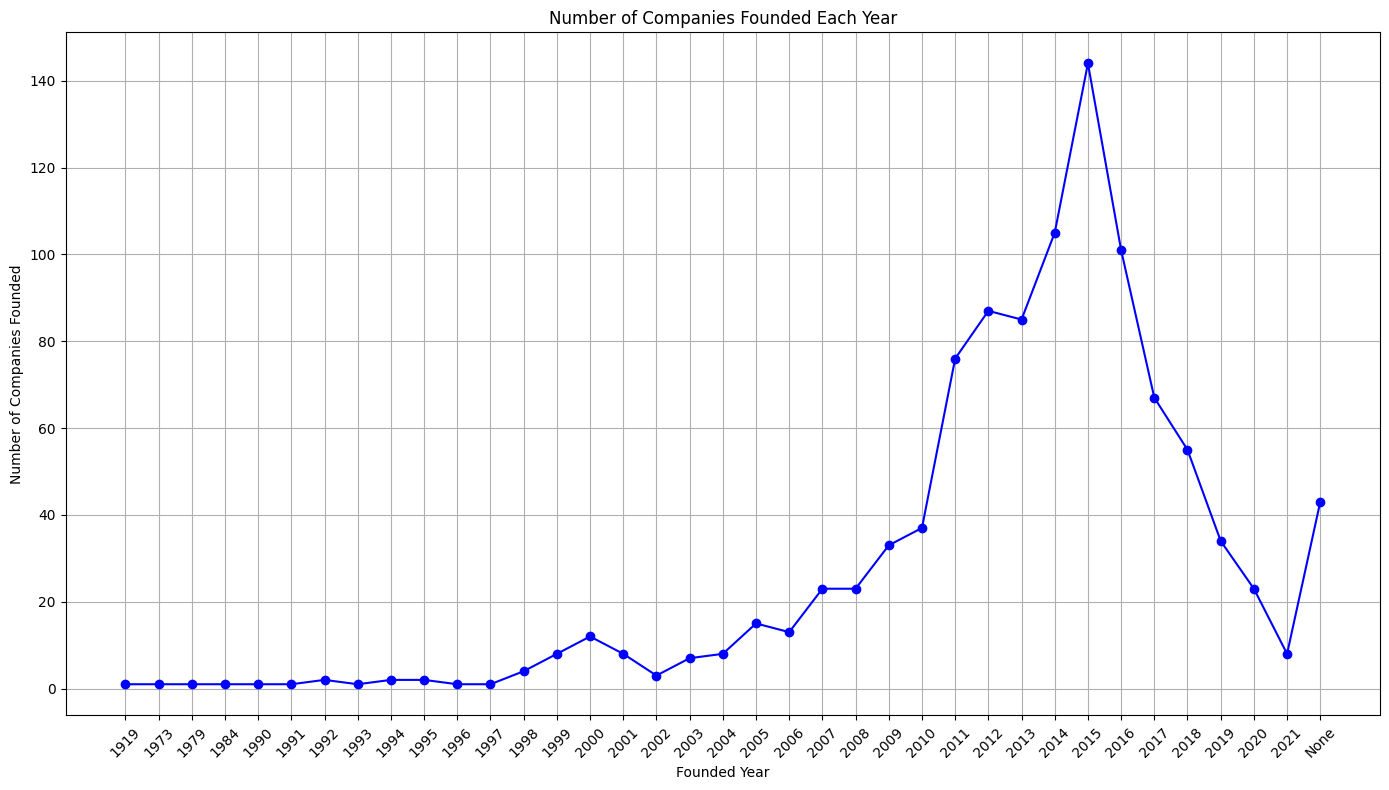

In [128]:
# Drop rows with missing values in the 'Founded Year' column
df_cleaned = unicornData.dropna(subset=['Founded Year'])

# Group by 'Founded Year' and aggregate the count of companies
grouped = df_cleaned.groupby('Founded Year')['Company'].count()

# Plotting a line chart for the time series
plt.figure(figsize=(14, 8))
plt.plot(grouped.index, grouped.values, marker='o', color='blue', linestyle='-')
plt.xlabel('Founded Year')
plt.ylabel('Number of Companies Founded')
plt.title('Number of Companies Founded Each Year')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


### Insight:
- This line chart visualization offers a comprehensive view of the historical trends and patterns of company founding, the same as previous visualizatio but with line graph.

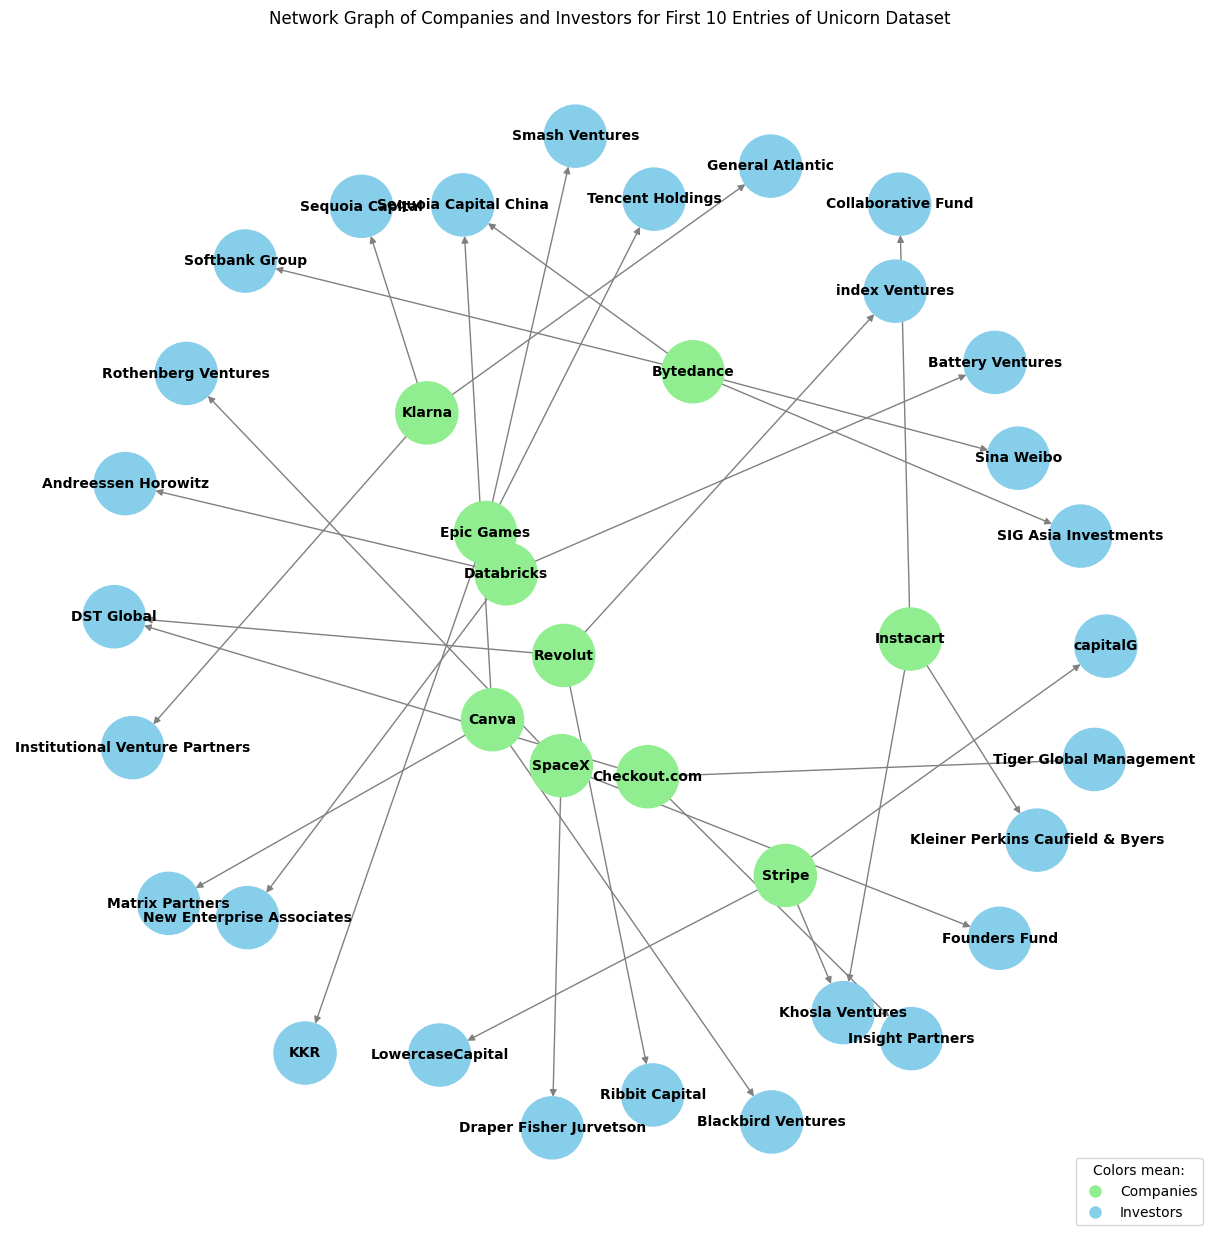

In [140]:
import networkx as nx

subset_data = unicornData.head(10)
# Create a directed graph
G = nx.DiGraph()

# Add companies and investors as nodes
for index, row in subset_data.iterrows():
    company = row['Company']
    investors = row['Select Inverstors'].split(',')
    G.add_node(company, node_type='company')
    for investor in investors:
        G.add_node(investor.strip(), node_type='investor')
        G.add_edge(company,investor.strip())

# Assign different colors to nodes based on their type
node_colors = {'company': 'lightgreen', 'investor': 'skyblue'}
colors = [node_colors[G.nodes[node]['node_type']] for node in G.nodes]


# Draw the graph
plt.figure(figsize=(12, 12))
pos = nx.spring_layout(G)  # Layout for the graph
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=colors, font_size=10, font_weight='bold', edge_color='gray', arrowsize=10)
legend_labels = {'Companies': 'lightgreen', 'Investors': 'skyblue'}
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=10) for label, color in legend_labels.items()]
plt.legend(handles=legend_handles, title='Colors mean:', loc='lower right')
plt.title('Network Graph of Companies and Investors for First 10 Entries of Unicorn Dataset')
plt.show()

#### Insights:
- The network graph provides a visual representation of the investment landscape within the subset of companies analyzed. It offers insights into the distribution of capital, the interconnectedness of stakeholders, and the dynamics of investment flows in the startup ecosystem.
- The edges connecting investors to companies highlight the direct investment links between them. Investors provide capital to companies in exchange for equity or other forms of ownership, facilitating the growth and expansion of startups.
- Network graph offers a comprehensive view of the relationships between companies and investors, enabling stakeholders to identify key players, understand investment patterns, and explore opportunities for collaboration and growth within the startup ecosystem.

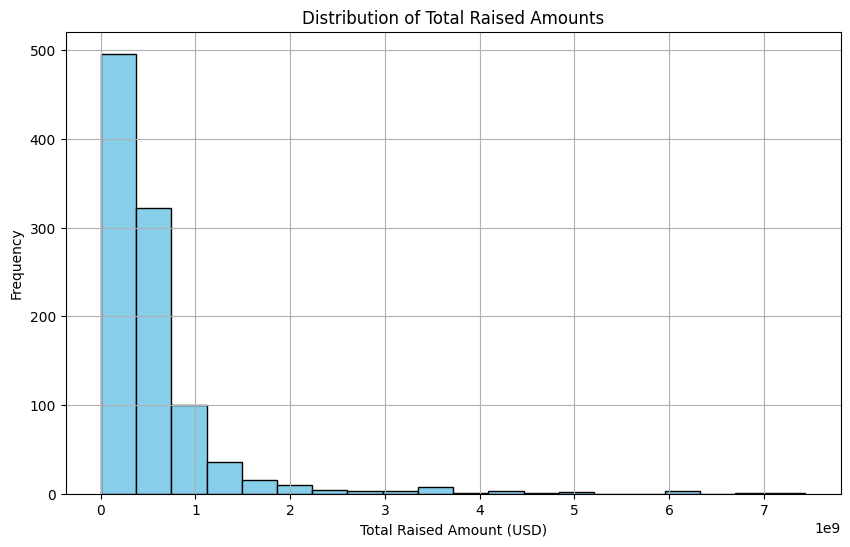

In [148]:
# Plot the Total Raised data
# First we clean and remove unnecessary data from this column
unicornData['Total Raised'] = pd.to_numeric(unicornData['Total Raised'].str.replace(r'[\$,]', '', regex=True).str.replace(r'[Bb]', 'e9', regex=True).str.replace(r'[Mm]', 'e6', regex=True), errors='coerce')


# Histogram of total raised amounts
plt.figure(figsize=(10, 6))
plt.hist(unicornData['Total Raised'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Total Raised Amount (USD)')
plt.ylabel('Frequency')
plt.title('Distribution of Total Raised Amounts')
plt.grid(True)
plt.show()

### Insights:
- The histogram shows a right-skewed distribution, indicating that a majority of unicorn companies have raised relatively smaller amounts of capital, while fewer companies have secured significantly higher funding.
- Analyzing the distribution of total raised amounts can provide insights into investment trends within the startup ecosystem.
- The presence of outliers on the right side of the histogram indicates a few unicorn companies that have raised exceptionally large amounts of capital. These outliers represent high-profile startups that have attracted substantial investments, potentially due to their innovative business models, strong growth potential, or market dominance.

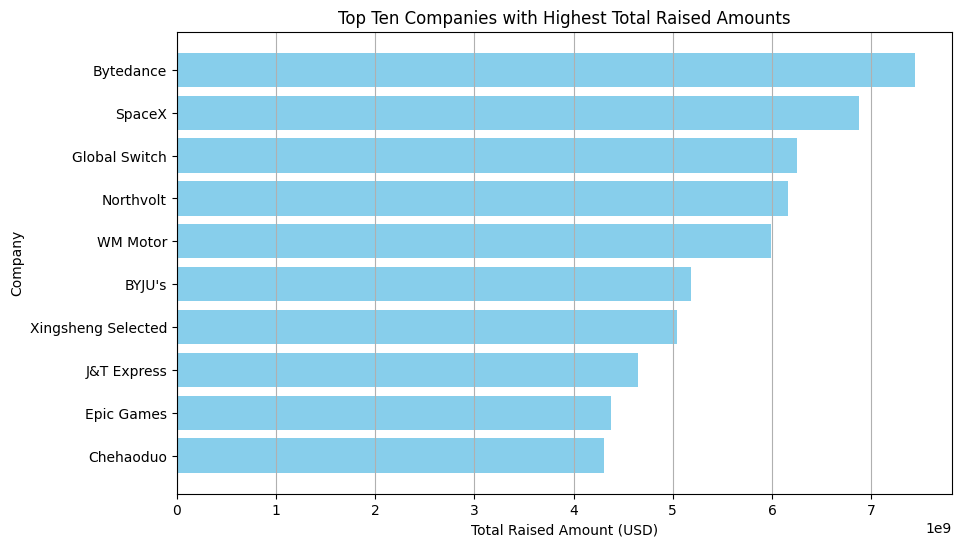

In [149]:
# Find the ten companies with the highest total raised amounts
top_ten_companies = unicornData.nlargest(10, 'Total Raised')[['Company', 'Total Raised']]

# Plotting
plt.figure(figsize=(10, 6))
plt.barh(top_ten_companies['Company'], top_ten_companies['Total Raised'], color='skyblue')
plt.xlabel('Total Raised Amount (USD)')
plt.ylabel('Company')
plt.title('Top Ten Companies with Highest Total Raised Amounts')
plt.gca().invert_yaxis()  # Invert y-axis to display the highest raised company at the top
plt.grid(axis='x')  # Add gridlines along the x-axis
plt.show()

### Insights:
- Companies with large funding rounds may be better positioned to disrupt industries, innovate, and capture market share.
- Companies with higher total raised amounts may have a strategic advantage over their competitors, as they possess greater financial resources to fuel their growth initiatives, expand market presence, and invest in research and development.

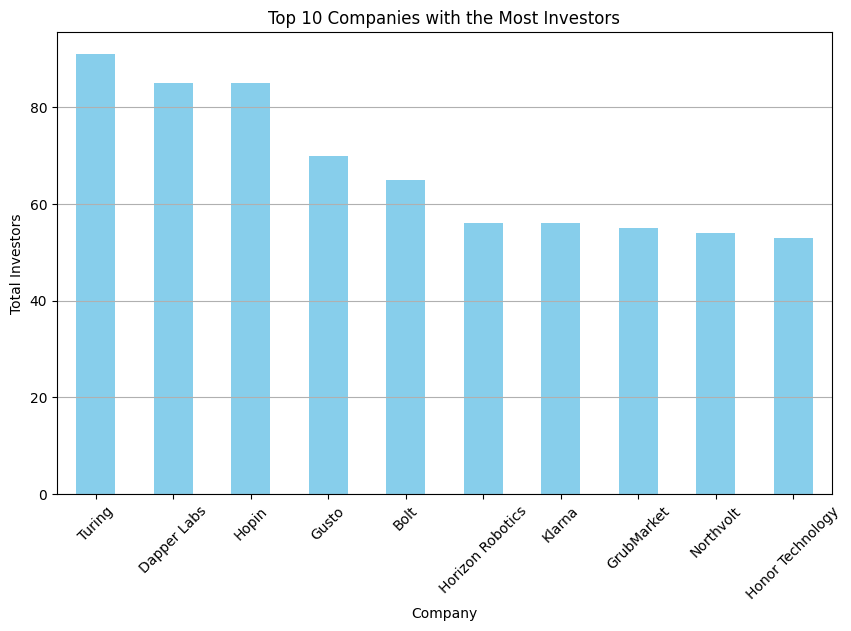

In [151]:
# Convert 'Investors Count' column to numeric
unicornData['Investors Count'] = pd.to_numeric(unicornData['Investors Count'], errors='coerce')

# Group by company name and sum the number of investors for each company
investors_per_company = unicornData.groupby('Company')['Investors Count'].sum()

# Sort the companies by the total number of investors and select the top 10
top_10_companies = investors_per_company.nlargest(10)

# Plotting
plt.figure(figsize=(10, 6))
top_10_companies.plot(kind='bar', color='skyblue')
plt.xlabel('Company')
plt.ylabel('Total Investors')
plt.title('Top 10 Companies with the Most Investors')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.show()


### Insights:
- Companies with a large number of investors may have established strategic partnerships or collaborations with multiple stakeholders.
- The visualization highlights the attractiveness of certain companies to investors, as reflected by the total number of investors associated with each company.
- The top 10 companies identified in the visualization may represent market leaders or disruptors within their respective industries. Investors may view these companies as having a competitive edge or significant market opportunity, leading to increased investment interest.

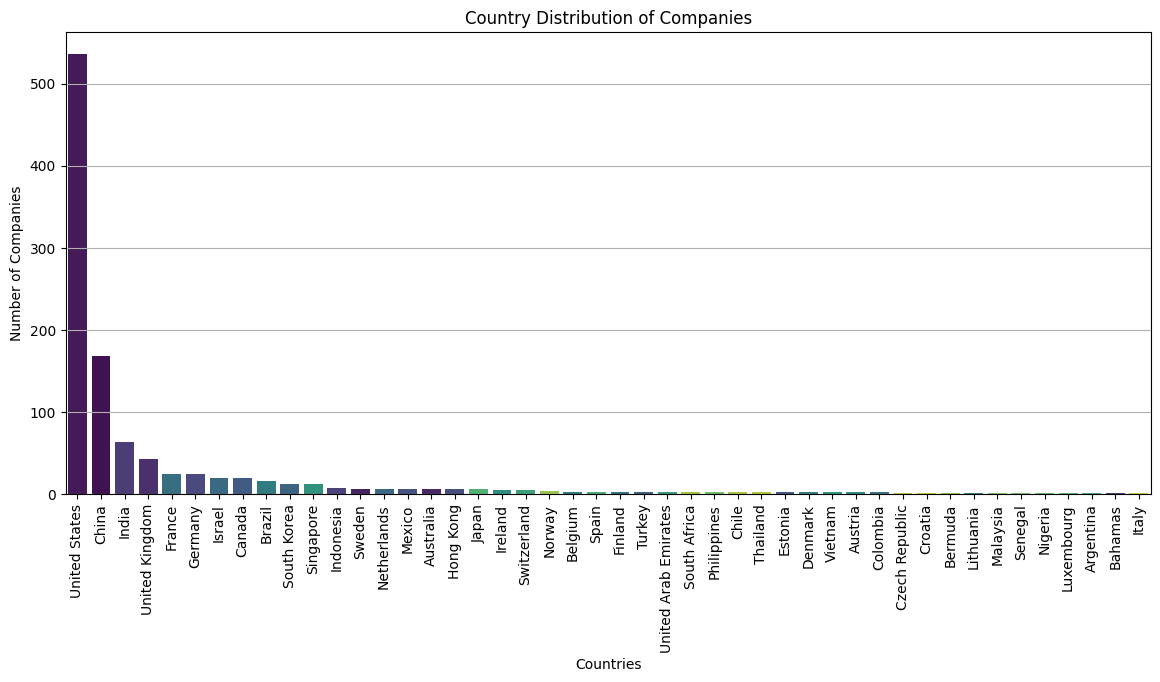

In [154]:
import seaborn as sns
# Plotting
plt.figure(figsize=(14, 6))
sns.countplot(data=unicornData, x='Country', order=unicornData['Country'].value_counts().index, hue='Country', palette='viridis', legend=False)
plt.title('Country Distribution of Companies')
plt.xlabel('Countries')
plt.ylabel('Number of Companies')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.grid(axis='y')  # Add gridlines along the y-axis
plt.show()


### Insights:
- The plot illustrates the distribution of unicorn companies across various countries, indicating the concentration of entrepreneurial activity in specific geographic regions.
- The plot may reveal the emergence of new startup ecosystems and innovation hubs in previously underrepresented regions.
- The visualization highlights the global reach of unicorn companies, showcasing their presence in diverse countries and regions around the world. This global dispersion underscores the interconnectedness of the startup landscape and the opportunities for cross-border collaboration, investment, and market expansion.

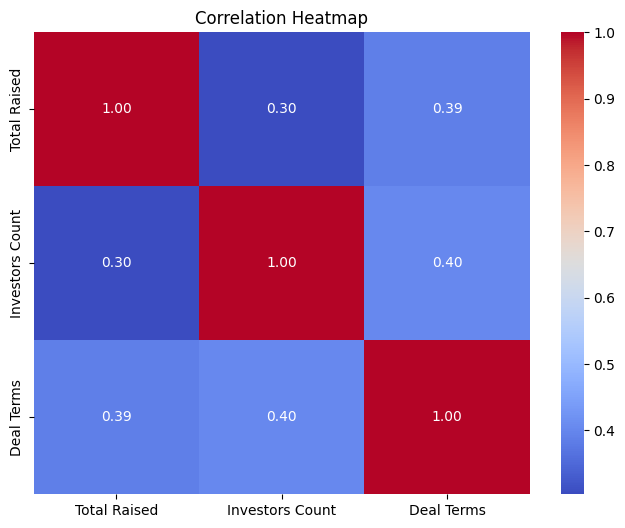

In [155]:
# Convert 'Deal Terms' column to integers
unicornData['Deal Terms'] = pd.to_numeric(unicornData['Deal Terms'], errors='coerce')

# Drop rows with NaN values in 'Deal Terms' and 'Total Raised' columns
unicornData.dropna(subset=['Deal Terms', 'Total Raised'], inplace=True)

# Compute correlation matrix
correlation_matrix = unicornData[['Total Raised', 'Investors Count', 'Deal Terms']].corr()

# Plot heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


### Insights:
- The correlation coefficient between "Total Raised" and "Investors Count" indicates a weak positive correlation. This suggests that there is a slight tendency for companies with more investors to have higher total raised amounts, although the relationship is not very strong.
- The correlation coefficient between "Total Raised" and "Deal Terms" suggests a weak positive correlation. This implies that there may be a slight tendency for companies with higher total raised amounts to have higher deal terms.
- The correlation coefficient between "Investors Count" and "Deal Terms" is moderate positive, indicating almost no linear relationship between the number of investors and deal terms.

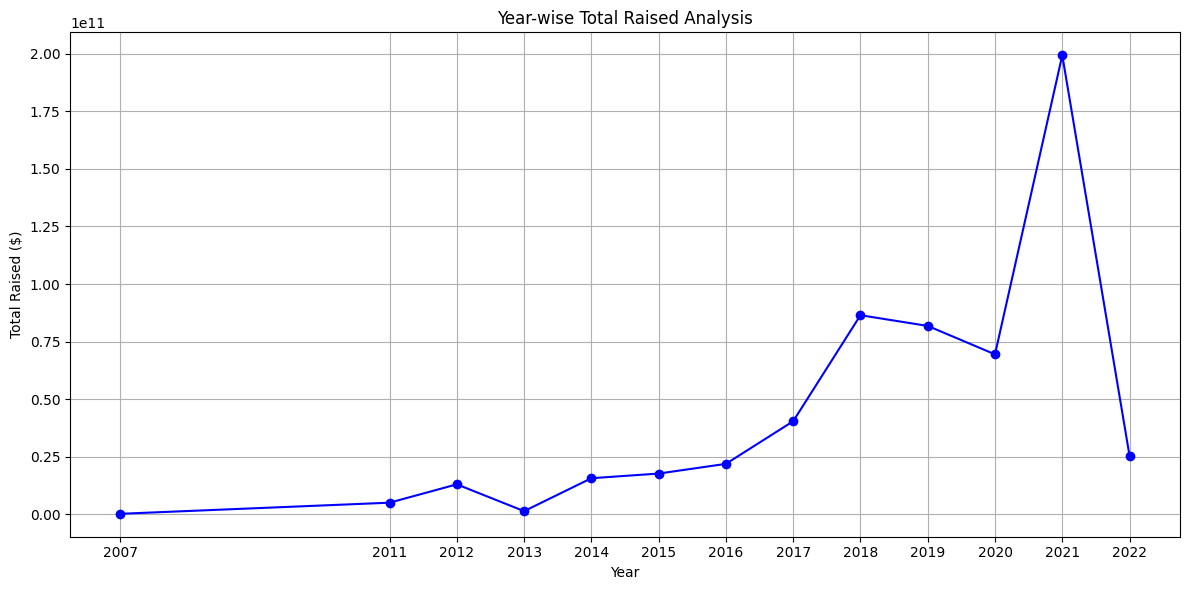

In [159]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'unicornData' is your DataFrame with relevant columns: 'Valuation ($B)', 'Total Raised', 'Date Joined'

# Convert 'Date Joined' column to datetime
unicornData['Date Joined'] = pd.to_datetime(unicornData['Date Joined'])

# Extract the year from the 'Date Joined' column
unicornData['Year_Joined'] = unicornData['Date Joined'].dt.year

# Group the data by year and aggregate the metrics
yearly_metrics = unicornData.groupby('Year_Joined').agg({
    'Total Raised': 'sum',      # Sum of total raised for each year
}).reset_index()

# Plot the total raised over the years
plt.figure(figsize=(12, 6))

# Plot total raised over the years
plt.plot(yearly_metrics['Year_Joined'], yearly_metrics['Total Raised'], marker='o', color='blue')

# Customize plot
plt.title('Year-wise Total Raised Analysis')
plt.xlabel('Year')
plt.ylabel('Total Raised ($)')
plt.grid(True)
plt.xticks(yearly_metrics['Year_Joined'])  # Ensure all years are displayed on x-axis
plt.tight_layout()

# Show plot
plt.show()


### Insights:
- The plot visualizes the trend of total funds raised by companies each year. By observing the plotted line, you can identify whether the total funds raised are increasing, decreasing, or remaining relatively stable over time.
- Analyzing the peaks and troughs in the plot allows you to understand the yearly fluctuations in fundraising activities.


In [160]:
import pandas as pd
import statsmodels.api as sm

# Convert 'Deal Terms' to numeric
unicornData['Deal Terms'] = pd.to_numeric(unicornData['Deal Terms'], errors='coerce')

# Drop rows with missing values
unicornData.dropna(subset=['Total Raised', 'Investors Count', 'Deal Terms'], inplace=True)

# Define predictor variables (X) and target variable (y)
X = unicornData[['Investors Count', 'Deal Terms']]
y = unicornData['Total Raised']

# Add constant to predictor variables
X = sm.add_constant(X)

# Fit regression model
model = sm.OLS(y, X).fit()

# Print summary of the regression model
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:           Total Raised   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     105.1
Date:                Thu, 29 Feb 2024   Prob (F-statistic):           4.13e-42
Time:                        15:41:35   Log-Likelihood:                -21615.
No. Observations:                 994   AIC:                         4.324e+04
Df Residuals:                     991   BIC:                         4.325e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            4.851e+07   4.32e+07     

### Insights:
- Both predictor variables ("Investors Count" and "Deal Terms") are statistically significant, as evidenced by their low p-values (p < 0.05). This suggests that they have a significant linear relationship with the "Total Raised" amount.
- The regression model indicates that both "Investors Count" and "Deal Terms" are important predictors of the "Total Raised" amount for unicorn companies. However, the model's low R-squared value suggests that there may be other factors not included in the model that also influence the "Total Raised" amount.

In [162]:
%%capture
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Select relevant features for clustering
features = ['Total Raised', 'Investors Count']

# Drop rows with missing values in selected features
data_for_clustering = unicornData[features].dropna()

# Standardize the features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data_for_clustering)

# Determine the optimal number of clusters using the elbow method
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(scaled_data)
    inertia_values.append(kmeans.inertia_)

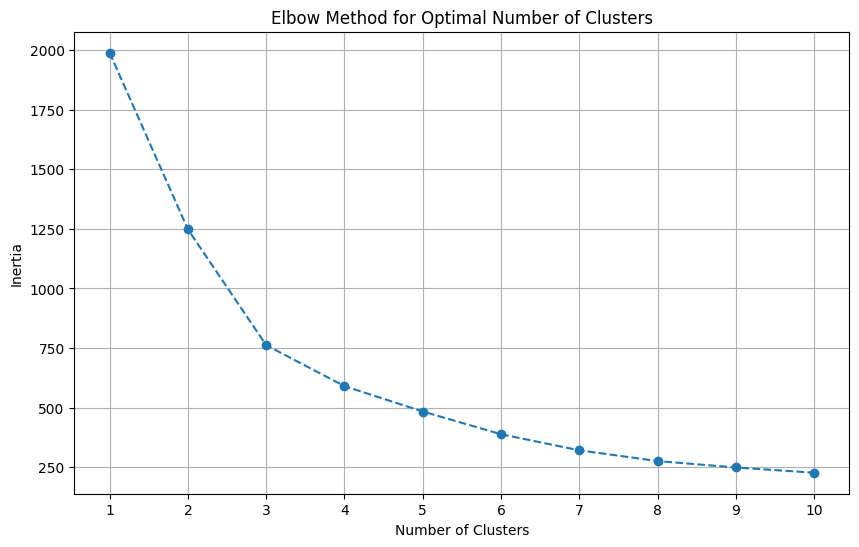

In [163]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xticks(range(1, 11))
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


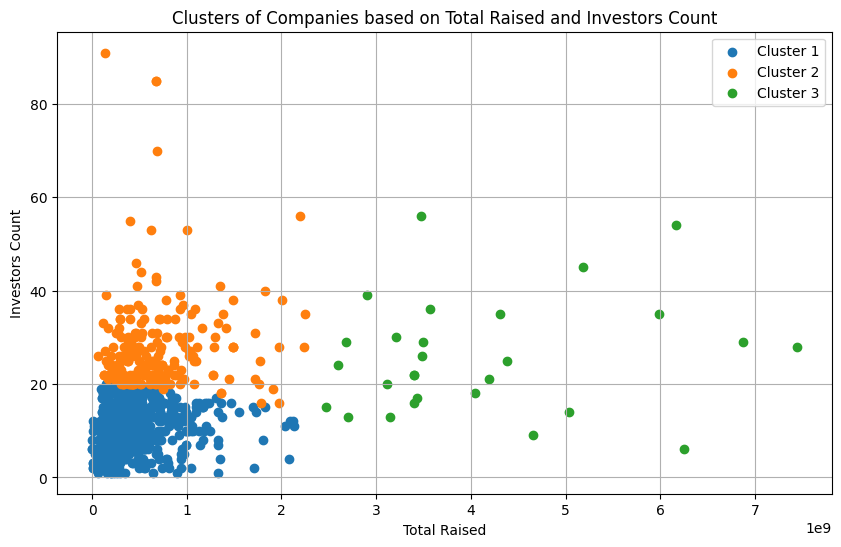

In [165]:
# Based on the elbow method, choose the optimal number of clusters
optimal_k = 3  # Adjust this based on the elbow curve

# Perform K-means clustering
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(scaled_data)

# Add cluster labels to the dataset
data_for_clustering['Cluster'] = clusters

# Plot the clusters
plt.figure(figsize=(10, 6))
for cluster in range(optimal_k):
    cluster_data = data_for_clustering[data_for_clustering['Cluster'] == cluster]
    plt.scatter(cluster_data['Total Raised'], cluster_data['Investors Count'], label=f'Cluster {cluster + 1}')

plt.xlabel('Total Raised')
plt.ylabel('Investors Count')
plt.title('Clusters of Companies based on Total Raised and Investors Count')
plt.legend()
plt.grid(True)
plt.show()

### Insights:
- Once companies are clustered into groups, it becomes easier to identify opportunities or areas of focus within each cluster. This can inform targeted marketing strategies, investment opportunities, or other business decisions.
- By clustering companies based on their features, the analysis can reveal groups of companies that share similar traits. This can help in identifying patterns or commonalities among companies, which can be useful for market analysis.